## Import library

In [30]:
import torch
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from glob import glob
from tqdm.auto import tqdm

from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchsummary import summary

from sklearn.model_selection import train_test_split

%matplotlib inline

### Visualize data

In [ ]:
data_dir = "./flowers"
data = {"label": [], "img_path": []}

for label in glob(f"{data_dir}/*"):
    label = label.split("/")[-1]
    for img_path in glob(f"{data_dir}/{label}/*"):
        data['label'].append(label)
        data['img_path'].append(img_path)

df = pd.DataFrame.from_dict(data)

In [49]:
data_dir = os.getcwd() + "/flowers"
train_dir = os.getcwd() + "/data/train"
test_dir = os.getcwd() + "/data/test"

data_dict = {}

for label in glob(data_dir + "/*"):
    label = label.split("/")[-1]

    data_dict[label] = glob(f"{data_dir}/{label}/*")

for label, img_list in data_dict.items():
    train_folder = f"{train_dir}/{label}"
    test_folder = f"{test_dir}/{label}"

    #     create folder if not exist
    if not os.path.exists(train_folder):
        os.mkdir(train_folder)
    if not os.path.exists(test_folder):
        os.mkdir(test_folder)

#     train test split
    train_img_list, test_img_list = train_test_split(img_list,
                                                     test_size=0.2,
                                                     shuffle=True)

    #     copy to folder
    for train_img in train_img_list:
        os.system(f"cp {train_img} {train_folder}")

    for test_img in test_img_list:
        os.system(f"cp {test_img} {test_folder}")

In [ ]:
df['label'].value_counts(), df['label'].unique()

In [ ]:
sns.set(font_scale=1.4)
df['label'].value_counts().plot(kind='barh', figsize=(7, 5), rot=0)
plt.title("Number of images per class")
plt.ylabel("Class", labelpad=14)
plt.xlabel("Number of images", labelpad=14)
plt.show()

### Load data with PyTorch

In [8]:
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

inv_normalize = transforms.Normalize(
    [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    [1 / 0.229, 1 / 0.224, 1 / 0.225])


def imshow(im):
    plt.figure(figsize=(10, 10))
    plt.imshow(im.numpy().transpose(1, 2, 0))

In [9]:
train_dir = "./data/train/"
test_dir = "./data/test/"

train_ds = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_ds = datasets.ImageFolder(root=test_dir, transform=test_transform)

train_ds

Dataset ImageFolder
    Number of datapoints: 3452
    Root location: ./data/train/
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [10]:
class_names = train_ds.classes
class_names, len(train_ds), len(test_ds)

(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], 3452, 865)

In [11]:
BATCH_SIZE = 10

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

### Visualize Data loader

In [12]:
for images, labels in train_loader:
    print(f"Label: {labels.numpy()}")
    print(f"Class: ", *[class_names[i] for i in labels])
    break

im = make_grid(images, nrow=5)

Label: [2 3 2 4 1 3 2 4 3 1]
Class:  rose sunflower rose tulip dandelion sunflower rose tulip sunflower dandelion


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


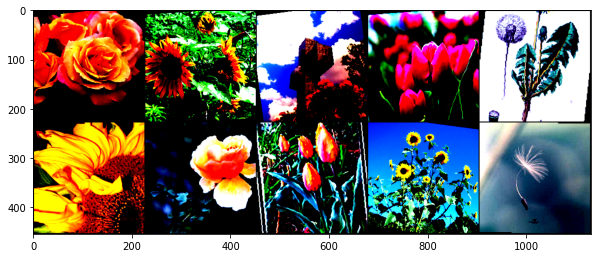

In [13]:
imshow(im)

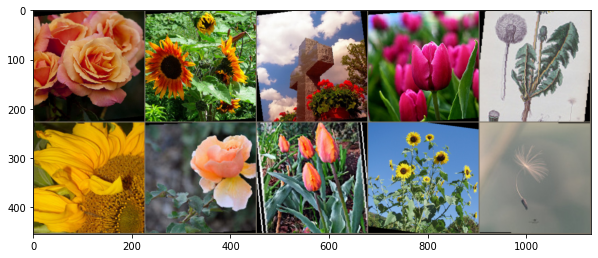

In [14]:
imshow(inv_normalize(im))

### Define CNN Model

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(16 * 54 * 54, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 20)
        self.fc4 = nn.Linear(20, 5)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 16 * 54 * 54)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)

        return F.log_softmax(X, dim=1)

In [21]:
summary(model, (3, 224, 224), batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [1, 6, 222, 222]             168
            Conv2d-2          [1, 16, 109, 109]             880
            Linear-3                   [1, 120]       5,598,840
            Linear-4                    [1, 84]          10,164
            Linear-5                    [1, 20]           1,700
            Linear-6                     [1, 5]             105
Total params: 5,611,857
Trainable params: 5,611,857
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 3.71
Params size (MB): 21.41
Estimated Total Size (MB): 25.69
----------------------------------------------------------------


### Train model

In [42]:
def training_loops(n_epochs, model, train_loader, optimizer, loss_fn):
    for epoch in range(n_epochs):
        loss = 0

        train_obj = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}")

        for imgs, labels in train_obj:
            # inference
            pred = model(imgs)
            loss = loss_fn(pred, labels)

            # optimzer
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_obj.set_postfix_str(f"train_loss: {loss:.3f}")

In [43]:
model = CNN()
loss_fn = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

n_epochs = 1

model.train()
training_loops(n_epochs, model, train_loader, optimizer, loss_fn)

Epoch 0/1:   0%|          | 0/346 [00:00<?, ?it/s]

### Measuring Accuracy

In [44]:
def validate(model, train_loader, test_loader):
    for name, loader in [("train", train_loader), ("test", test_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in tqdm(loader):

                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum().item())

            print(f"Accuracy {name}: {100*correct/total:3f} %")

In [46]:
validate(model, train_loader, test_loader)

  0%|          | 0/346 [00:00<?, ?it/s]

Accuracy train: 0.287949 %


  0%|          | 0/87 [00:00<?, ?it/s]

Accuracy test: 0.291329 %


### Save model

In [47]:
torch.save(model.state_dict(), "flower_cls.pt")